In [42]:
%matplotlib inline
import os
from collections import namedtuple
from collections import defaultdict
from collections import Counter
from datetime import datetime
import itertools
import base64
import glob
import json
import random
import time
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shutil
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import boto3
import botocore
import sagemaker
from urllib.parse import urlparse

In [43]:
#BUCKET = "object-detection-smartsolution"
BUCKET = "object-detection-gt-lalteng"
EXP_NAME = "colleague"

In [44]:
# Load the output manifest's annotations.
#OUTPUT_MANIFEST = "s3://object-detection-gt-lalteng/colleague/output/ground-truth-colleague-demo-2021103001/manifests/output/output.manifest"
OUTPUT_MANIFEST = "s3://object-detection-gt-lalteng/colleague/output/demo-0313-01/manifests/output/output.manifest"
!aws s3 cp {OUTPUT_MANIFEST} 'output.manifest'

with open("output.manifest", "r") as f:
    output = [json.loads(line.strip()) for line in f.readlines()]

download: s3://object-detection-gt-lalteng/colleague/output/demo-0313-01/manifests/output/output.manifest to ./output.manifest


# Train an object detection model using Ground Truth labels

In [45]:
with open("output.manifest", "r") as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)

dataset_size = len(output)
train_test_split_index = round(dataset_size * 0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open("train.manifest", "w") as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write("\n")
        num_training_samples += 1

with open("validation.manifest", "w") as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write("\n")

In [46]:
!aws s3 cp train.manifest s3://{BUCKET}/{EXP_NAME}/train.manifest
!aws s3 cp validation.manifest s3://{BUCKET}/{EXP_NAME}/validation.manifest

upload: ./train.manifest to s3://object-detection-gt-lalteng/colleague/train.manifest
upload: ./validation.manifest to s3://object-detection-gt-lalteng/colleague/validation.manifest


In [47]:
import re
from sagemaker import get_execution_role
from time import gmtime, strftime

role = get_execution_role()
sess = sagemaker.Session()
s3 = boto3.resource("s3")

#取得object detection image uri
training_image = sagemaker.amazon.amazon_estimator.get_image_uri(
    boto3.Session().region_name, "object-detection", repo_version="latest"
)
print(training_image)
augmented_manifest_filename_train = "train.manifest"
augmented_manifest_filename_validation = "validation.manifest"
bucket_name = BUCKET
s3_prefix = EXP_NAME
s3_output_path = "s3://{}/{}/trainingjob/colleague-augmented-manifest-output".format(
    bucket_name,s3_prefix
)  # Replace with your desired output directory.

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


In [48]:
# Defines paths for use in the training job request.
s3_train_data_path = "s3://{}/{}/{}".format(
    bucket_name, s3_prefix, augmented_manifest_filename_train
)
s3_validation_data_path = "s3://{}/{}/{}".format(
    bucket_name, s3_prefix, augmented_manifest_filename_validation
)

print("Augmented manifest for training data: {}".format(s3_train_data_path))
print("Augmented manifest for validation data: {}".format(s3_validation_data_path))

Augmented manifest for training data: s3://object-detection-gt-lalteng/colleague/train.manifest
Augmented manifest for validation data: s3://object-detection-gt-lalteng/colleague/validation.manifest


In [49]:
augmented_manifest_s3_key = s3_train_data_path.split(bucket_name)[1][1:]
s3_obj = s3.Object(bucket_name, augmented_manifest_s3_key)
augmented_manifest = s3_obj.get()["Body"].read().decode("utf-8")
augmented_manifest_lines = augmented_manifest.split("\n")
num_training_samples = len(
    augmented_manifest_lines
)  # Compute number of training samples for use in training job request.
# Determine the keys in the training manifest and exclude the meta data from the labling job.
attribute_names = list(json.loads(augmented_manifest_lines[0]).keys())
attribute_names = [attrib for attrib in attribute_names if "meta" not in attrib]

In [78]:
# Create unique job name
job_name_prefix = "smartsolution-demo-resnet-500-512"
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
model_job_name = job_name_prefix + timestamp

training_params = {
    "AlgorithmSpecification": {
        # NB. This is one of the named constants defined in the first cell.
        "TrainingImage": training_image,
        "TrainingInputMode": "Pipe",
    },
    "RoleArn": role,
    "OutputDataConfig": {"S3OutputPath": s3_output_path},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.p3.8xlarge", "VolumeSizeInGB": 50},
    "TrainingJobName": model_job_name,
    "HyperParameters": {  # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
        #"base_network": "vgg-16",#['resnet-50']
        "base_network": "resnet-50",#['resnet-50']
        "use_pretrained_model": "1",
        "num_classes": "12",
        "mini_batch_size": "8",
        #"epochs": "5",
        "epochs": "500",
        "learning_rate": "0.001",
        "lr_scheduler_step": "",
        "lr_scheduler_factor": "0.1",
        "optimizer": "sgd", #['sgd', 'adam', 'rmsprop', 'adadelta']
        "momentum": "0.9",
        "weight_decay": "0.0005",
        "overlap_threshold": "0.5",
        "nms_threshold": "0.45",
        "image_shape": "512",#300
        "label_width": "350",
        "num_training_samples": str(num_training_samples),
    },
    "StoppingCondition": {
        #"MaxWaitTimeInSeconds": 86400,
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                    "S3Uri": s3_train_data_path,
                    "S3DataDistributionType": "FullyReplicated",
                    # NB. This must correspond to the JSON field names in your augmented manifest.
                    "AttributeNames": attribute_names,
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",  # NB. Augmented Manifest
                    "S3Uri": s3_validation_data_path,
                    "S3DataDistributionType": "FullyReplicated",
                    # NB. This must correspond to the JSON field names in your augmented manifest.
                    "AttributeNames": attribute_names,
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None",
        },
    ]#,
    #"EnableManagedSpotTraining": True #demo 拿掉
}

print("Training job name: {}".format(model_job_name))
print(
    "\nInput Data Location: {}".format(
        training_params["InputDataConfig"][0]["DataSource"]["S3DataSource"]
    )
)

Training job name: smartsolution-demo-resnet-500-512-2022-03-13-06-56-55

Input Data Location: {'S3DataType': 'AugmentedManifestFile', 'S3Uri': 's3://object-detection-gt-lalteng/colleague/train.manifest', 'S3DataDistributionType': 'FullyReplicated', 'AttributeNames': ['source-ref', 'demo-0313-01']}


In [79]:
client = boto3.client(service_name="sagemaker")
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=model_job_name)["TrainingJobStatus"]
print("Training job current status: {}".format(status))

Training job current status: InProgress


In [80]:
client = boto3.client(service_name="sagemaker")
print(
    "Training job status: ",
    client.describe_training_job(TrainingJobName=model_job_name)["TrainingJobStatus"],
)
print(
    "Secondary status: ",
    client.describe_training_job(TrainingJobName=model_job_name)["SecondaryStatus"],
)

Training job status:  InProgress
Secondary status:  Starting


In [37]:
client = boto3.client(service_name="sagemaker")
model_job_name = 'ground-truthod-demo-colleague-vgg16-512-2021-10-30-09-44-32'

In [54]:
training_info = client.describe_training_job(TrainingJobName=model_job_name)

## Create Model

In [55]:
sagemaker_client =  boto3.client('sagemaker')
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
model_name = "smartsolution-demo-vgg16-model" + timestamp
print(model_name)
model_data = training_info["ModelArtifacts"]["S3ModelArtifacts"]
print(model_data)

primary_container = {
    "Image": training_image,
    "ModelDataUrl": model_data
}

create_model_response = sagemaker_client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

smartsolution-demo-vgg16-model-2022-03-13-06-48-09
s3://object-detection-gt-lalteng/colleague/trainingjob/colleague-augmented-manifest-output/smartsolution-demo-vgg16-512-2022-03-13-06-13-42/output/model.tar.gz
arn:aws:sagemaker:us-east-1:241082659383:model/smartsolution-demo-vgg16-model-2022-03-13-06-48-09


### Create Endpoint Configuration

In [56]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config_name = job_name_prefix + "-epc" + timestamp
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint configuration name: {}".format(endpoint_config_name))
print("Endpoint configuration arn:  {}".format(endpoint_config_response["EndpointConfigArn"]))

Endpoint configuration name: smartsolution-demo-vgg16-512-epc-2022-03-13-06-48-16
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:241082659383:endpoint-config/smartsolution-demo-vgg16-512-epc-2022-03-13-06-48-16


### Create Endpoint

In [57]:
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = job_name_prefix + "-ep" + timestamp
print("Endpoint name: {}".format(endpoint_name))

endpoint_params = {
    "EndpointName": endpoint_name,
    "EndpointConfigName": endpoint_config_name,
}
endpoint_response = sagemaker_client.create_endpoint(**endpoint_params)
print("EndpointArn = {}".format(endpoint_response["EndpointArn"]))

# get the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = response["EndpointStatus"]
print("EndpointStatus = {}".format(status))

# wait until the status has changed
sagemaker_client.get_waiter("endpoint_in_service").wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

Endpoint name: smartsolution-demo-vgg16-512-ep-2022-03-13-06-48-24
EndpointArn = arn:aws:sagemaker:us-east-1:241082659383:endpoint/smartsolution-demo-vgg16-512-ep-2022-03-13-06-48-24
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


### Perform inference

In [ ]:
#smartsolution-demo-vgg16-512-epc-2021-11-07-14-18-19
#endpoint_name='demo'

In [74]:
#test_image = 'test/14465735511528.jpg'
#test_image = 'test/IMG_0645.jpg'
#test_image = 'test/IMG_4794.jpg'
#test_image = 'test/line_637535308359381.jpg'
test_image = 'test/IMG_2573.jpg'

In [75]:
with open(test_image, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

client = boto3.client("sagemaker-runtime")
response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)

result = response["Body"].read()
result = json.loads(result)

predictions = [prediction for prediction in result["prediction"] if prediction[1] > 0.3]
print(predictions)

[[0.0, 0.9306358098983765, 0.32421958446502686, 0.18505334854125977, 0.7367458343505859, 0.44942963123321533], [8.0, 0.3396381437778473, 0.32014816999435425, 0.14473207294940948, 0.7552251219749451, 0.3990459442138672]]


In [76]:
from ground_truth_od import BoundingBox, WorkerBoundingBox, GroundTruthBox, BoxedImage

def make_predicted_image(predictions, img_id, uri):
    """Maked a BoxedImage object with output of batch/realtime prediction.

    Args:
      predictions: list, output of get_predictions.
      uri: str, s3 uri of input image.

    Returns:
      BoxedImage object with predicted bounding boxes.
    """
    img = BoxedImage(id=img_id, uri=uri)
    img.download("test")
    imread_img = img.imread()
    imh, imw, *_ = imread_img.shape
    
    # Create boxes.
    for batch_data in predictions:
        class_id, confidence, xmin, ymin, xmax, ymax = batch_data
        boxdata = {
            "class_id": class_id,
            "height": (ymax - ymin) * imh,
            "width": (xmax - xmin) * imw,
            "left": xmin * imw,
            "top": ymin * imh,
        }
        box = BoundingBox(boxdata=boxdata, image_id=img.id)
        img.consolidated_boxes.append(box)

    return img

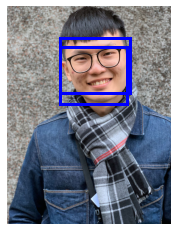

In [77]:
realtime_uri = test_image
realtime_img = make_predicted_image(predictions, "RealtimeTest", realtime_uri)

# Plot the realtime prediction.
fig, ax = plt.subplots()
realtime_img.download("test")
realtime_img.plot_consolidated_bbs(ax)

### Clean up

In [25]:
boto3.client(service_name="sagemaker").delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '8a538430-cfb8-453f-8657-c23e951c01be',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8a538430-cfb8-453f-8657-c23e951c01be',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 16 Nov 2021 01:10:32 GMT'},
  'RetryAttempts': 0}}